## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torchvision.transforms as T
import torch

In [3]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [2]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Model Testing

In [5]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [6]:
iteration =  iter(test_dataloader)

In [7]:

images , target1 = next(iteration)
imgs = list(img for img in images)

In [8]:
image1 = imgs

In [9]:
images , target2 = next(iteration)
imgs = list(img for img in images)

In [10]:
image2 = imgs

In [11]:
images , target3 = next(iteration)
imgs = list(img for img in images)

In [14]:
img3 = imgs[0]

In [12]:
# Concatenate the images along the horizontal dimension (dim=3)
import torch.nn.functional as F
img1 = image1[0]
img2 = image2[0]

# Resize the smaller image tensors to match the dimensions of the largest tensor
if img1.shape[1:] != img2.shape[1:]:
    img1 = F.interpolate(img1.unsqueeze(0), size=img2.shape[1:], mode='nearest').squeeze(0)
if img1.shape[1:] != img3.shape[1:]:
    img1 = F.interpolate(img1.unsqueeze(0), size=img3.shape[1:], mode='nearest').squeeze(0)
if img2.shape[1:] != img3.shape[1:]:
    img2 = F.interpolate(img2.unsqueeze(0), size=img3.shape[1:], mode='nearest').squeeze(0)


combined_imgs = torch.cat((img1, img2,img3), dim=2)



In [13]:
comp = torch.cat((img1, img2), dim=2)
comp = torch.cat((comp, img3), dim=2)

In [14]:
image1[0].shape

torch.Size([3, 1160, 590])

In [15]:
combined_imgs.shape

torch.Size([3, 814, 1785])

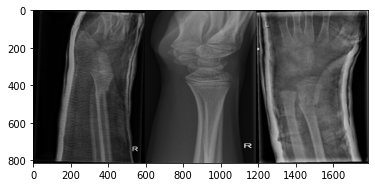

In [16]:
# Convert the combined image tensor to a numpy array
import numpy as np
import matplotlib.pyplot as plt
combined_img_np = combined_imgs.cpu().numpy()

# Transpose the numpy array to match the channel-last format required by matplotlib
combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

# Display the combined image using matplotlib
plt.imshow(combined_img_np)
plt.show()

In [97]:
bbox1 = target1[0]["boxes"]

In [98]:
bbox2 = target2[0]["boxes"]

In [99]:
bbox1

tensor([[ 520., 1034.,  552., 1070.],
        [ 321.,  575.,  404.,  654.]])

In [38]:
import torch

def resize_image(image, bbox, new_height, new_width):
    # Resize the image
    h, w = image.shape[1:]

    pad_tb = max(0, new_height - h)
    pad_lr = max(0, new_width - w)
    pad_top = pad_tb // 2
    pad_bottom = pad_tb - pad_top
    pad_left = pad_lr // 2
    pad_right = pad_lr - pad_left

    # add padding
    image = torch.nn.functional.pad(image, (pad_left, pad_right, pad_top, pad_bottom))


    resized_image = torch.nn.functional.interpolate(image.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=True).squeeze(0)
    
    # Scale the bounding boxes accordingly
    scale_factor_x = new_width / (w + pad_lr)
    scale_factor_y = new_height / (h + pad_tb)
    scaled_bbox = torch.stack([bbox[:, 0] * scale_factor_x + pad_left, bbox[:, 1] * scale_factor_y + pad_top, bbox[:, 2] * scale_factor_x + pad_left, bbox[:, 3] * scale_factor_y + pad_top], dim=1)

    
    return resized_image, scaled_bbox

In [39]:
import torch

def concatenate_images(image1, bbox1, image2, bbox2):
    # Get the dimensions of the two images
    _, height1, width1 = image1.shape
    _, height2, width2 = image2.shape
    
    # Determine the new size of the concatenated image
    new_height = max(height1, height2)
    new_width = max(width1, width2)
    
    # Resize the two images
    resized_image1, scaled_bbox1 = resize_image(image1, bbox1, new_height, new_width)
    resized_image2, scaled_bbox2 = resize_image(image2, bbox2, new_height, new_width)

    
    # Adjust the bounding box coordinates for the second image
    scaled_bbox2[:, [0, 2]] += new_width
    
    
    # Concatenate the two images
    concatenated_image = torch.cat((resized_image1, resized_image2), dim=2)
    
    return concatenated_image, scaled_bbox1, scaled_bbox2


In [137]:
img1 = image1[0]
img2 = image2[0]
concatenated_image, scaled_bbox1, scaled_bbox2 = concatenate_images(img1, bbox1, img2, bbox2)

In [138]:
img2.shape

torch.Size([3, 976, 353])

In [139]:
concatenated_image.shape

torch.Size([3, 1160, 1180])

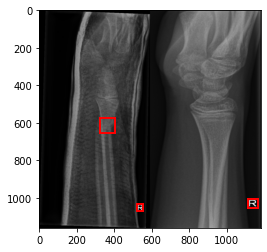

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the combined image tensor to a numpy array
combined_img_np = concatenated_image.cpu().numpy()

# Transpose the numpy array to match the channel-last format required by matplotlib
combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

# Create a figure and axis object
fig, ax = plt.subplots()

# Display the image
ax.imshow(combined_img_np)

# Plot the bounding boxes
for box in scaled_bbox1:
    # Extract the coordinates of the box
    x_min, y_min, x_max, y_max = box
    
    # Create a rectangle patch object
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle patch to the axis
    ax.add_patch(rect)

# Plot the bounding boxes
for box in scaled_bbox2:
    # Extract the coordinates of the box
    x_min, y_min, x_max, y_max = box
    
    # Create a rectangle patch object
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle patch to the axis
    ax.add_patch(rect)

# Show the plot
plt.show()


In [40]:
import torch

def concatenate_images_and_bboxes(images, bboxes):
    # Get the dimensions of the images
    heights = [image.shape[1] for image in images]
    widths = [image.shape[2] for image in images]

    # Determine the new size of the concatenated image
    new_height = max(heights)
    new_width = max(widths)

    # Resize and adjust the bounding boxes for each image
    resized_images = []
    scaled_bboxes = []
    
    for i in range(len(images)):
        # Resize the image and bbox
        resized_image, scaled_bbox = resize_image(images[i], bboxes[i], new_height, new_width)

        # Adjust the bbox coordinates based on the x_offset
        scaled_bbox[:, [0, 2]] += new_width * i

        # Add the resized image and bbox to the lists
        resized_images.append(resized_image)
        scaled_bboxes.append(scaled_bbox)

    # Concatenate the resized images along the width dimension
    concatenated_image = torch.cat(resized_images, dim=2)

    # Stack the scaled bboxes into a single tensor
    concatenated_bboxes = torch.cat(scaled_bboxes)

    return concatenated_image, concatenated_bboxes


In [17]:
img1 = image1[0]
img2 = image2[0]

In [18]:
bbox1 = target1[0]["boxes"]
bbox2 = target2[0]["boxes"]
bbox3 = target3[0]["boxes"]

bboxes = [bbox1,bbox2,bbox3]

In [19]:
image_list = [img1,img2,img3]


In [20]:
concatenated_image, concatenated_bboxes = concatenate_images_and_bboxes(image_list, bboxes)

In [90]:
bboxes

[tensor([[ 520., 1034.,  552., 1070.],
         [ 321.,  575.,  404.,  654.]]),
 tensor([[312., 848., 344., 885.]]),
 tensor([[220., 456., 330., 557.],
         [128., 458., 212., 506.],
         [ 47.,  64.,  70.,  95.],
         [  4., 198.,  19., 216.]])]

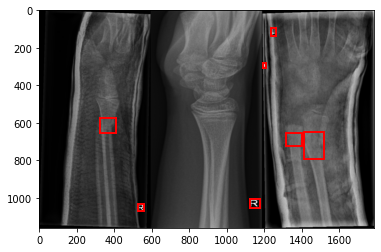

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the combined image tensor to a numpy array
combined_img_np = concatenated_image.cpu().numpy()

# Transpose the numpy array to match the channel-last format required by matplotlib
combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

# Create a figure and axis object
fig, ax = plt.subplots()

# Display the image
ax.imshow(combined_img_np)

# Plot the bounding boxes
for box in concatenated_bboxes:
    # Extract the coordinates of the box
    x_min, y_min, x_max, y_max = box
    
    # Create a rectangle patch object
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle patch to the axis
    ax.add_patch(rect)

# Show the plot
plt.show()


In [23]:
concatenated_image.shape

torch.Size([3, 1160, 1785])

# Preprocessing steps to merge images and fix bboxes


In [68]:
import json

# Load the JSON file as a dictionary
with open('../data/train_coco_data.json', 'r') as f:
    data = json.load(f)

# Extract the file_names from the "images" key
file_names = [img['file_name'] for img in data['images']]

# Print the list of file_names
print(file_names)

['../literature/Other/supervisely/wrist/rpg_images/0001_1297860395_01_WRI-L1_M014.png', '../literature/Other/supervisely/wrist/rpg_images/0001_1297860435_01_WRI-L2_M014.png', '../literature/Other/supervisely/wrist/rpg_images/0002_0354485759_01_WRI-R2_F012.png', '../literature/Other/supervisely/wrist/rpg_images/0002_0354485735_01_WRI-R1_F012.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0663715782_02_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0662359226_01_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0664918633_03_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0663715732_02_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0664918693_03_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0662359351_01_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0004_0542630513_01_WRI-L2_M003.png', '../literature/Other/supervisely/wrist/rpg

In [69]:
file_names

['../literature/Other/supervisely/wrist/rpg_images/0001_1297860395_01_WRI-L1_M014.png',
 '../literature/Other/supervisely/wrist/rpg_images/0001_1297860435_01_WRI-L2_M014.png',
 '../literature/Other/supervisely/wrist/rpg_images/0002_0354485759_01_WRI-R2_F012.png',
 '../literature/Other/supervisely/wrist/rpg_images/0002_0354485735_01_WRI-R1_F012.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0663715782_02_WRI-R2_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0662359226_01_WRI-R1_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0664918633_03_WRI-R1_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0663715732_02_WRI-R1_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0664918693_03_WRI-R2_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0003_0662359351_01_WRI-R2_M011.png',
 '../literature/Other/supervisely/wrist/rpg_images/0004_0542630513_01_WRI-L2_M003.png',
 '../literature/Other/supervisel

In [70]:
file_names = [path.replace('.png', '.pickle') for path in file_names]

In [71]:
file_names = [path.replace('rpg_images', 'train_pickles_new') for path in file_names]

In [72]:
file_names

['../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860435_01_WRI-L2_M014.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485759_01_WRI-R2_F012.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485735_01_WRI-R1_F012.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715782_02_WRI-R2_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359226_01_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918633_03_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715732_02_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918693_03_WRI-R2_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359351_01_WRI-R2_M011.pickle',
 '../literature/Othe

In [73]:
# Extract the file name and split it using "_" character
import os
import pandas as pd

data = []
for path in file_names:
    file_name = os.path.basename(path)
    parts = file_name.split("_")
    data.append(parts)

# Create a Pandas DataFrame with the data
df = pd.DataFrame(data, columns=['id', 'hash', 'study number', 'region_projection', 'sex_age'])

df["path"] = file_names

# Print the resulting DataFrame
df.head()

,id,hash,study number,region_projection,sex_age,path
0,0001,1297860395,01,WRI-L1,M014.pickle,../literature/Other/supervisely/wrist/train_pi...
1,0001,1297860435,01,WRI-L2,M014.pickle,../literature/Other/supervisely/wrist/train_pi...
2,0002,0354485759,01,WRI-R2,F012.pickle,../literature/Other/supervisely/wrist/train_pi...
3,0002,0354485735,01,WRI-R1,F012.pickle,../literature/Other/supervisely/wrist/train_pi...
4,0003,0663715782,02,WRI-R2,M011.pickle,../literature/Other/supervisely/wrist/train_pi...


In [74]:
df[df["id"] == "0022"]

,id,hash,study number,region_projection,sex_age,path


In [75]:
# Group the DataFrame by 'id' and 'study number' columns
groups = df.groupby(['id', 'study number'])

# Initialize an empty list to store the paths
paths_list = []

# Iterate over the groups and extract the paths that have the same 'id' and 'study number'
for _, group_df in groups:
    if len(group_df) >= 1:
        paths = list(group_df['path'])
        paths_list.append(paths)

# Print the resulting list of paths
paths_list

[['../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014.pickle',
  '../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860435_01_WRI-L2_M014.pickle'],
 ['../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485759_01_WRI-R2_F012.pickle',
  '../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485735_01_WRI-R1_F012.pickle'],
 ['../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359226_01_WRI-R1_M011.pickle',
  '../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359351_01_WRI-R2_M011.pickle'],
 ['../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715782_02_WRI-R2_M011.pickle',
  '../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715732_02_WRI-R1_M011.pickle'],
 ['../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918633_03_WRI-R1_M011.pickle',
  '../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918693_03_WRI-R2_M011.pickle'],
 ['..

In [76]:
len(paths_list)

8018

In [77]:
# Get the first group
first_group = groups.get_group(list(groups.groups.keys())[0])


In [78]:
first_group

,id,hash,study number,region_projection,sex_age,path
0,0001,1297860395,01,WRI-L1,M014.pickle,../literature/Other/supervisely/wrist/train_pi...
1,0001,1297860435,01,WRI-L2,M014.pickle,../literature/Other/supervisely/wrist/train_pi...


In [79]:
import pickle

# Open the pickle file in read-binary mode
with open('../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860435_01_WRI-L2_M014.pickle', 'rb') as f:
    # Load the contents of the pickle file
    data = pickle.load(f)

# Now you can use the 'data' variable to access the contents of the pickle file
print(data)

{'image': '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860435_01_WRI-L2_M014.png', 'target': {'boxes': tensor([[ 31., 680.,  84., 745.],
        [180., 428., 356., 508.]]), 'labels': tensor([2, 1]), 'image_id': tensor([1]), 'area': tensor([ 3445, 14080])}}


# Vision instection of the work so far


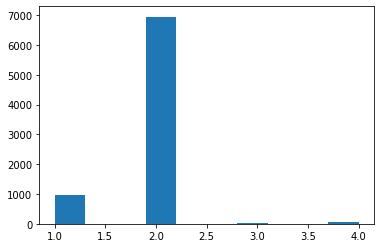

In [80]:
# Get the length of the inside lists
lengths = [len(l) for l in paths_list]

# Plot a histogram of the lengths
plt.hist(lengths)

# Show the plot
plt.show()

In [81]:
set(lengths)

{1, 2, 3, 4}

In [82]:
from tqdm import tqdm
def multi_view_data(pickle_list):
    i = 0 
    for list in pickle_list:

        img_list = []
        bboxes = []
        for p in list:

            with open(p, 'rb') as f:
                # Load the contents of the pickle file
                data = pickle.load(f)
            
            img_path = data['image']
            img = cv2.imread(img_path)
            img = T.ToTensor()(img).float()
            target = data['target']

            img_list.append(img)
            bboxes.append(target["boxes"])
        
        concatenated_image, concatenated_bboxes = concatenate_images_and_bboxes(img_list, bboxes)
        i=i+1
        # Convert the combined image tensor to a numpy array
        combined_img_np = concatenated_image.cpu().numpy()

        # Transpose the numpy array to match the channel-last format required by matplotlib
        combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

        # Create a figure and axis object
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(combined_img_np)

        # Plot the bounding boxes
        for box in concatenated_bboxes:
            # Extract the coordinates of the box
            x_min, y_min, x_max, y_max = box
            
            # Create a rectangle patch object
            rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
            
            # Add the rectangle patch to the axis
            ax.add_patch(rect)

        # Show the plot
        plt.show()
        if i == 20 : break

    return concatenated_image, concatenated_bboxes
        
    


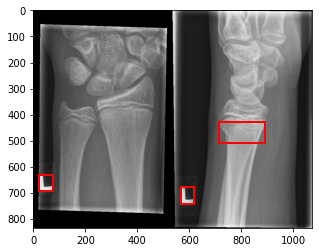

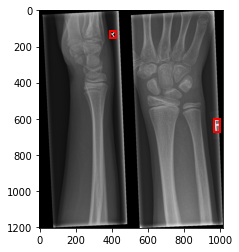

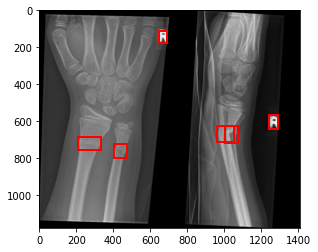

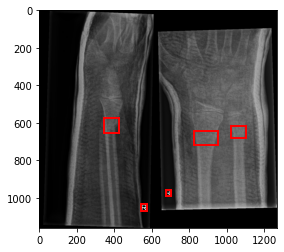

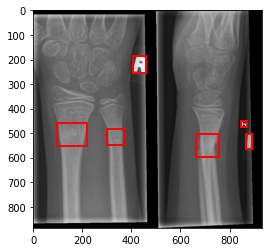

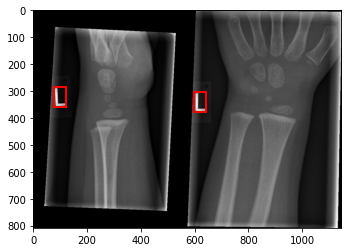

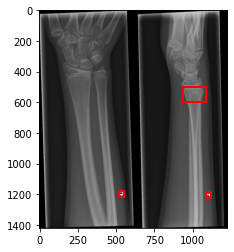

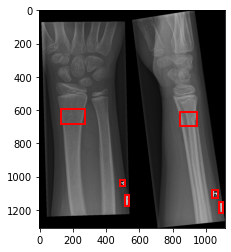

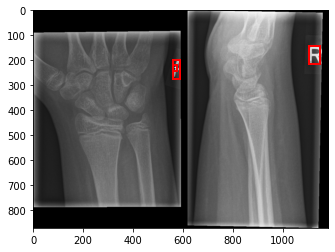

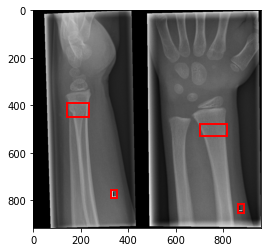

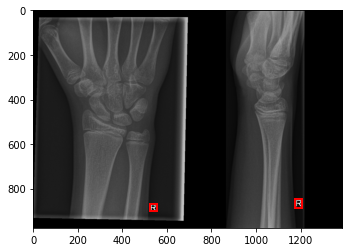

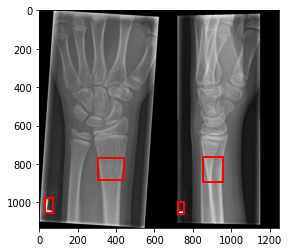

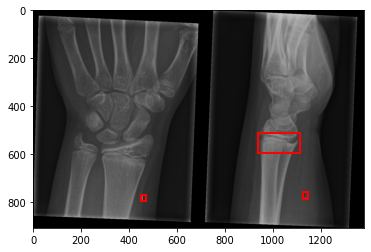

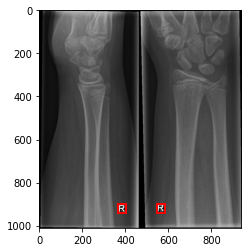

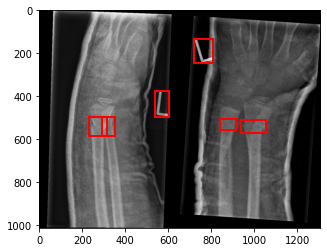

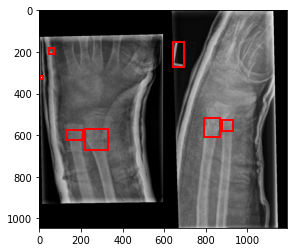

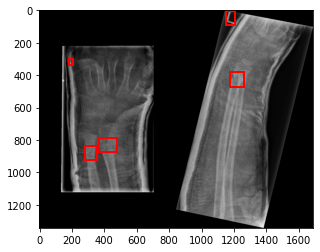

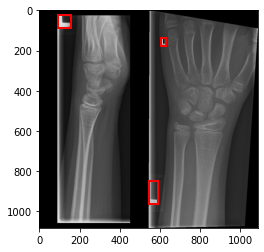

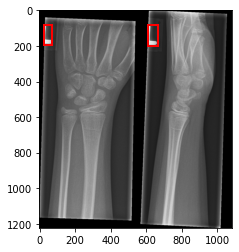

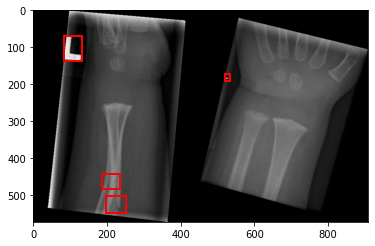

In [83]:
concatenated_image, concatenated_bboxes = multi_view_data(paths_list)

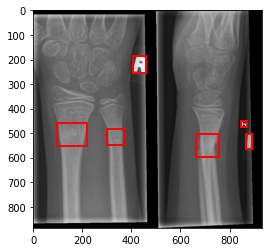

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the combined image tensor to a numpy array
combined_img_np = concatenated_image.cpu().numpy()

# Transpose the numpy array to match the channel-last format required by matplotlib
combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

# Create a figure and axis object
fig, ax = plt.subplots()

# Display the image
ax.imshow(combined_img_np)

# Plot the bounding boxes
for box in concatenated_bboxes:
    # Extract the coordinates of the box
    x_min, y_min, x_max, y_max = box
    
    # Create a rectangle patch object
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle patch to the axis
    ax.add_patch(rect)

# Show the plot
plt.show()


In [66]:
from tqdm import tqdm
import cv2
import numpy as np

def multi_view_data(pickle_list):

    root_dir = pathlib.Path('../literature/Other/supervisely')
    i = 0 

    for list in pickle_list:

        img_list = []
        bboxes = []
        labels = []
        d = {}
        for p in list:

            with open(p, 'rb') as f:
                # Load the contents of the pickle file
                data = pickle.load(f)
            
            img_path = data['image']
            img = cv2.imread(img_path)
            img = T.ToTensor()(img).float()
            target = data['target']

            img_list.append(img)
            bboxes.append(target["boxes"])
            labels.append(target["labels"])
        
        concatenated_image, concatenated_bboxes = concatenate_images_and_bboxes(img_list, bboxes)
        labels = torch.cat(labels)

        name = pathlib.PurePath(data['image']).name.split('.')[0]
        name = name.replace('L1', 'merge')
        name = name.replace('L2', 'merge')
        name = name.replace('L3', 'merge')
        name = name.replace('R1', 'merge')
        name = name.replace('R2', 'merge')
        name = name.replace('R3', 'merge')

        #save the image
        concatenated_image = concatenated_image.permute(1, 2, 0).numpy()

        # Convert the numpy array to the cv2.imread format
        cv2_image = cv2.cvtColor(np.uint8(concatenated_image * 255), cv2.COLOR_RGB2BGR)
        cv2.imwrite("../literature/Other/supervisely/wrist/merged_images/" +name+ ".png" , cv2_image)

        #fix the new annotation
        d["boxes"] = concatenated_bboxes
        d["labels"] = labels
        d["image_id"] = torch.tensor([i])

        i = i + 1
        

        target = d

        img = "..\\literature\\Other\\supervisely\\wrist\\merged_images\\"+name+".png"

        ready_data = {'image' : img,'target' : target}

        #save the pickle with the image path and the annotation
        path = os.path.join(root_dir,'wrist','train_pickles_mix', name + '.pickle')

        with open(path, 'wb') as handle:
            pickle.dump(ready_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



        
    


run this to make the files for multi-view


In [67]:
multi_view_data(paths_list)

In [179]:
with open("../literature/Other/supervisely/wrist/train_pickles_mix/0001_1297860435_01_WRI-merge_M014.pickle", 'rb') as f:
    
    data = pickle.load(f)

In [180]:
data

{'image': '..\\literature\\Other\\supervisely\\wrist\\merged_images\\0001_1297860435_01_WRI-merge_M014.png',
 'target': {'boxes': tensor([[ 22., 631.,  76., 695.],
          [567., 680., 620., 745.],
          [716., 428., 892., 508.]]),
  'labels': tensor([2, 2, 1]),
  'image_id': tensor([0])}}

In [188]:
img_path = data['image']
linux_path = os.path.join(*img_path.split('\\'))

img1 = cv2.imread(img_path)
img = T.ToTensor()(img1).float()

In [191]:
img.shape

torch.Size([3, 836, 1072])

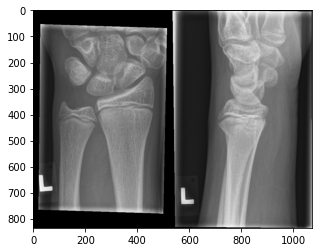

In [189]:
fig, ax = plt.subplots()
ax.imshow(img1)
plt.show()


In [186]:
from src.models.utils import *
model = get_model_instance_segmentation(3)
best_model = torch.load(f'../models/Best_val_CNN_Model.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1])


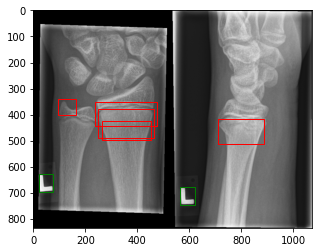

In [195]:
model.eval()
results_cnn = []
predictions = model([img])

print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(img,predictions[0])


In [193]:
predictions


[{'boxes': tensor([[566.1709, 678.3490, 621.0611, 747.8276],
          [ 22.1827, 628.7468,  77.4659, 699.6701],
          [712.0421, 415.8881, 887.5250, 513.9068],
          [249.1546, 378.0979, 462.8868, 490.8232],
          [262.9083, 423.8954, 454.4273, 498.9444],
          [ 93.7830, 341.3795, 163.0081, 402.0828],
          [236.2410, 353.2852, 474.1504, 445.8335]], grad_fn=<StackBackward0>),
  'labels': tensor([2, 2, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9993, 0.9992, 0.9959, 0.8244, 0.3891, 0.1462, 0.1080],
         grad_fn=<IndexBackward0>)}]

# Make a small test run 


In [5]:
from cv2 import cv2
import os
import json
import time
import pickle

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch
from src.models.utils import *
import wandb

In [8]:
#load train data
train_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/train_pickles_mix'))
training_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0,collate_fn=collate_fn)

In [ ]:
#load the model
model = get_model_instance_segmentation(3)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
    #optimizer = torch.optim.AdamW(params, lr=0.005, betas=(0.9, 0.999), weight_decay=0.0005)

optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

train_loss = []
val_loss = []

best_loss = 0

print('----------------------train started--------------------------')

for epoch in range(1):
        
    start = time.time()
    model.train()
    model.to(device)  
    
        #training step
    epoch_loss = train_one_epoch(model,training_dataloader,device,optimizer)
    train_loss.append(epoch_loss)
